In [44]:
import os
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
def load_images_from_flat_folder(folder_path, image_size=(100, 100)):
    X, y = [], []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            label = filename.split('-')[0]  
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                X.append(img.flatten())
                y.append(label)
    return np.array(X), np.array(y)
X, y = load_images_from_flat_folder("originalimages_part2")
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [46]:
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

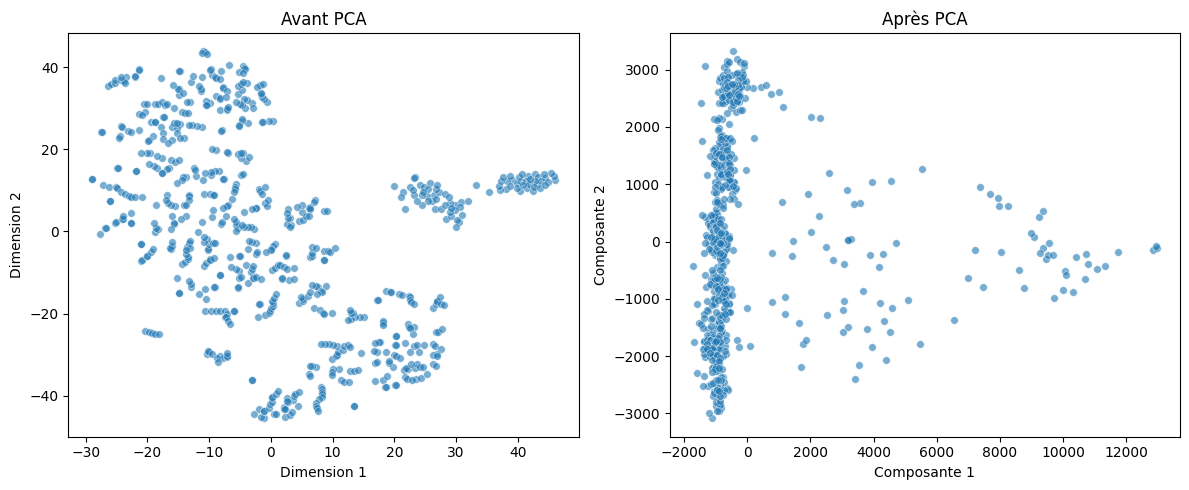

In [47]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Affichage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], s=30, alpha=0.6)
plt.title("Avant PCA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=30, alpha=0.6)
plt.title("Après PCA")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")

plt.tight_layout()
plt.show()

In [48]:
lda = LDA(n_components=min(len(np.unique(y_encoded)) - 1, 50))
X_lda = lda.fit_transform(X_pca, y_encoded)

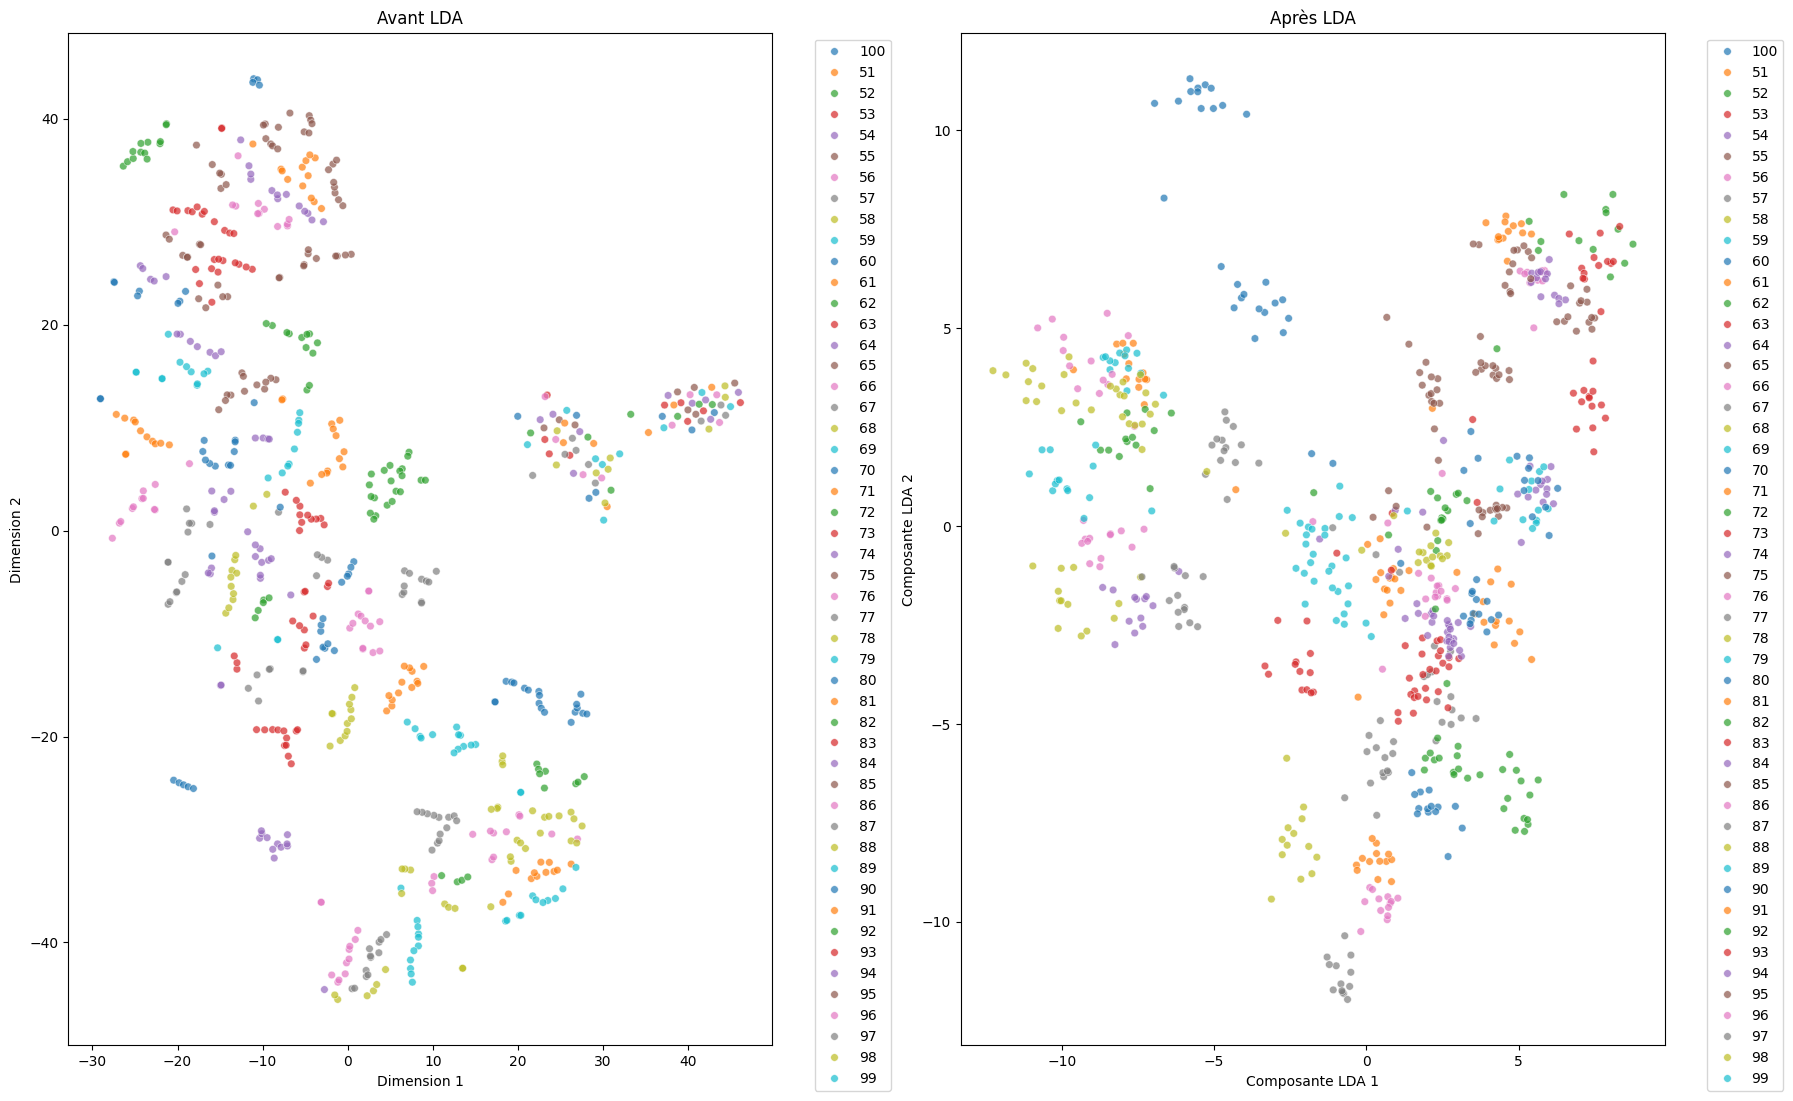

In [49]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

# Affichage comparatif
plt.figure(figsize=(18, 12))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, s=30, alpha=0.7, palette="tab10")
plt.title("Avant LDA")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_lda[:, 0], y=X_lda[:, 1], hue=y, s=30, alpha=0.7, palette="tab10")
plt.title("Après LDA")
plt.xlabel("Composante LDA 1")
plt.ylabel("Composante LDA 2" if X_lda.shape[1] > 1 else "")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_encoded, test_size=0.2, random_state=42)
X_train = X_train.reshape(-1, X_lda.shape[1], 1, 1)
X_test = X_test.reshape(-1, X_lda.shape[1], 1, 1)

In [51]:
model = models.Sequential([
    layers.Input(shape=(X_lda.shape[1], 1, 1)),
    layers.Conv2D(32, (3, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 1)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/10
70/70 [==============================] - 1s 3ms/step - loss: 3.1760 - accuracy: 0.2893 - val_loss: 2.1619 - val_accuracy: 0.5643
Epoch 2/10
70/70 [==============================] - 0s 2ms/step - loss: 1.1381 - accuracy: 0.8500 - val_loss: 0.6085 - val_accuracy: 0.9500
Epoch 3/10
70/70 [==============================] - 0s 2ms/step - loss: 0.3312 - accuracy: 0.9821 - val_loss: 0.3263 - val_accuracy: 0.9571
Epoch 4/10
70/70 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 0.9821 - val_loss: 0.2479 - val_accuracy: 0.9714
Epoch 5/10
70/70 [==============================] - 0s 2ms/step - loss: 0.1194 - accuracy: 0.9929 - val_loss: 0.2169 - val_accuracy: 0.9714
Epoch 6/10
70/70 [==============================] - 0s 2ms/step - loss: 0.0859 - accuracy: 0.9929 - val_loss: 0.1965 - val_accuracy: 0.9714
Epoch 7/10
70/70 [==============================] - 0s 2ms/step - loss: 0.0686 - accuracy: 0.9946 - val_loss: 0.1843 - val_accuracy: 0.9714
Epoch 8/10
70/70 [==

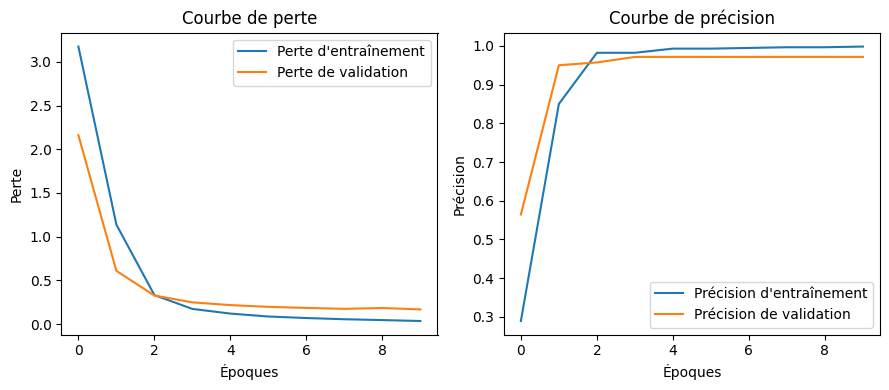

In [53]:
plt.figure(figsize=(9, 4))

# Courbe de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

# Courbe de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe de précision')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
# Étape 7 : Évaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Précision sur les données de test : {test_acc * 100:.2f}%")

5/5 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.9714
✅ Précision sur les données de test : 97.14%


In [55]:
# Fonction de prédiction d'image
def predict_face(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Image introuvable.")
        return
    img = cv2.resize(img, (100, 100)).flatten().reshape(1, -1)
    img_pca = pca.transform(img)
    img_lda = lda.transform(img_pca)
    img_lda = img_lda.reshape(-1, img_lda.shape[1], 1, 1)
    prediction = model.predict(img_lda)
    predicted_label = np.argmax(prediction)
    identity = le.inverse_transform([predicted_label])[0]
    # Affichage de l'image avec titre
    plt.imshow(img.reshape(100, 100), cmap='gray')
    plt.title(f"Visage reconnu : {identity}")
    plt.axis('off')
    plt.show()

    print(f"✅ Visage reconnu : {identity}")
    return identity

In [56]:
# Fonction de prédiction pour toutes les images d'un dossier
def predict_faces_in_folder(folder_path):
    results = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(folder_path, filename)
            try:
                identity = predict_face(img_path)
                results[filename] = identity
            except Exception as e:
                print(f"Erreur avec {filename} : {e}")
    return results

1/1 [==============================] - 0s 44ms/step


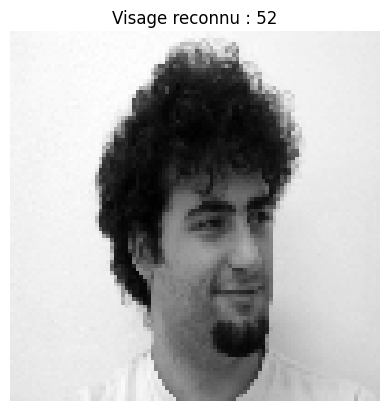

✅ Visage reconnu : 52


'52'

In [57]:
predict_face("originalimages_part2/52-08.jpg")